# Results for TSI set

In [1]:
# Imports & setups
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import artm
import plotly.graph_objects as go
import plotly.express as px
import random
import itertools
from concurrent.futures import ProcessPoolExecutor, as_completed
from wordcloud import WordCloud
from sklearn.cluster import SpectralClustering
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

In [2]:
tsi_data_path = '../Data/metadata/tsi_tf_1.csv'
tsi_data = pd.read_csv(tsi_data_path).sort_values(by='max_dimer_freq', ascending=False)

In [3]:
def df_tf_plot(data, title:str=None, threshold=0.5, ax=None):
    count_by_dim_freq = data.groupby('max_dimer_freq').agg({'term':'count'}).reset_index()
    if ax is None:
        ax = plt.gca()
    count_by_dim_freq.plot.bar(x='max_dimer_freq', y='term', legend=None,ax=ax)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_ylabel('term_count')

def plot_wordcloud(term_list:list, title:str=None, ax=None):
    long_string = ','.join(term_list)
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    
    # Adjust the plotting based on whether an ax is provided
    if ax is not None:
        # Use the provided axes object for plotting
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')  # Hide the axes
        if title is not None:
            ax.set_title(title)  # Set title if provided
    else:
        # No axes object provided, use plt to create and show the plot
        plt.figure(figsize=(6, 4))  # Optional: Adjust figure size
        plt.imshow(wordcloud, interpolation='bilinear')
        if title is not None:
            plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
           


def check_threshold(data,value=0.5):
    print(f'Testing with dimer frequency threshold = {value}.')
    noise = data[data['max_dimer_freq']>=value]
    df_tf_plot(noise, title='Noise term distribution by dimer frequency')
    plot_wordcloud(noise['term'], title='Noise wordcloud')
    clean = data[data['max_dimer_freq']<value]
    display(noise.tail(15))
    df_tf_plot(clean, title='Clean data term distribution by dimer frequency')
    plot_wordcloud(clean['term'], title='Clean data wordcloud')

def grid_plot(data, step=0.1):
    thresholds = np.arange(0, 1.1, step)
    nrows = len(thresholds)  # Determined by the number of thresholds
    ncols = 4  # Fixed number of columns: two for df_tf plots, two for word clouds
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))  # Adjusted figsize for better layout
    
    for i, threshold in enumerate(thresholds):
        noise = data[data['max_dimer_freq'] >= threshold]
        clean = data[data['max_dimer_freq'] < threshold]
        
        # Adjusting call to df_tf_plot and plot_wordcloud to use current axis
        if not noise.empty:
            df_tf_plot(noise, title=f'Noise >= {threshold:.1f}', threshold=threshold, ax=axs[i, 0])
            plot_wordcloud(noise['term'].tolist(), title='Noise Wordcloud', ax=axs[i, 2])
        else:
            axs[i, 0].text(0.5, 0.5, 'No noise data', ha='center', va='center', transform=axs[i, 0].transAxes)
            axs[i, 2].axis('off')
        
        if not clean.empty:
            df_tf_plot(clean, title=f'Clean < {threshold:.1f}', threshold=threshold, ax=axs[i, 1])
            plot_wordcloud(clean['term'].tolist(), title='Clean Wordcloud', ax=axs[i, 3])
        else:
            axs[i, 1].text(0.5, 0.5, 'No clean data', ha='center', va='center', transform=axs[i, 1].transAxes)
            axs[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

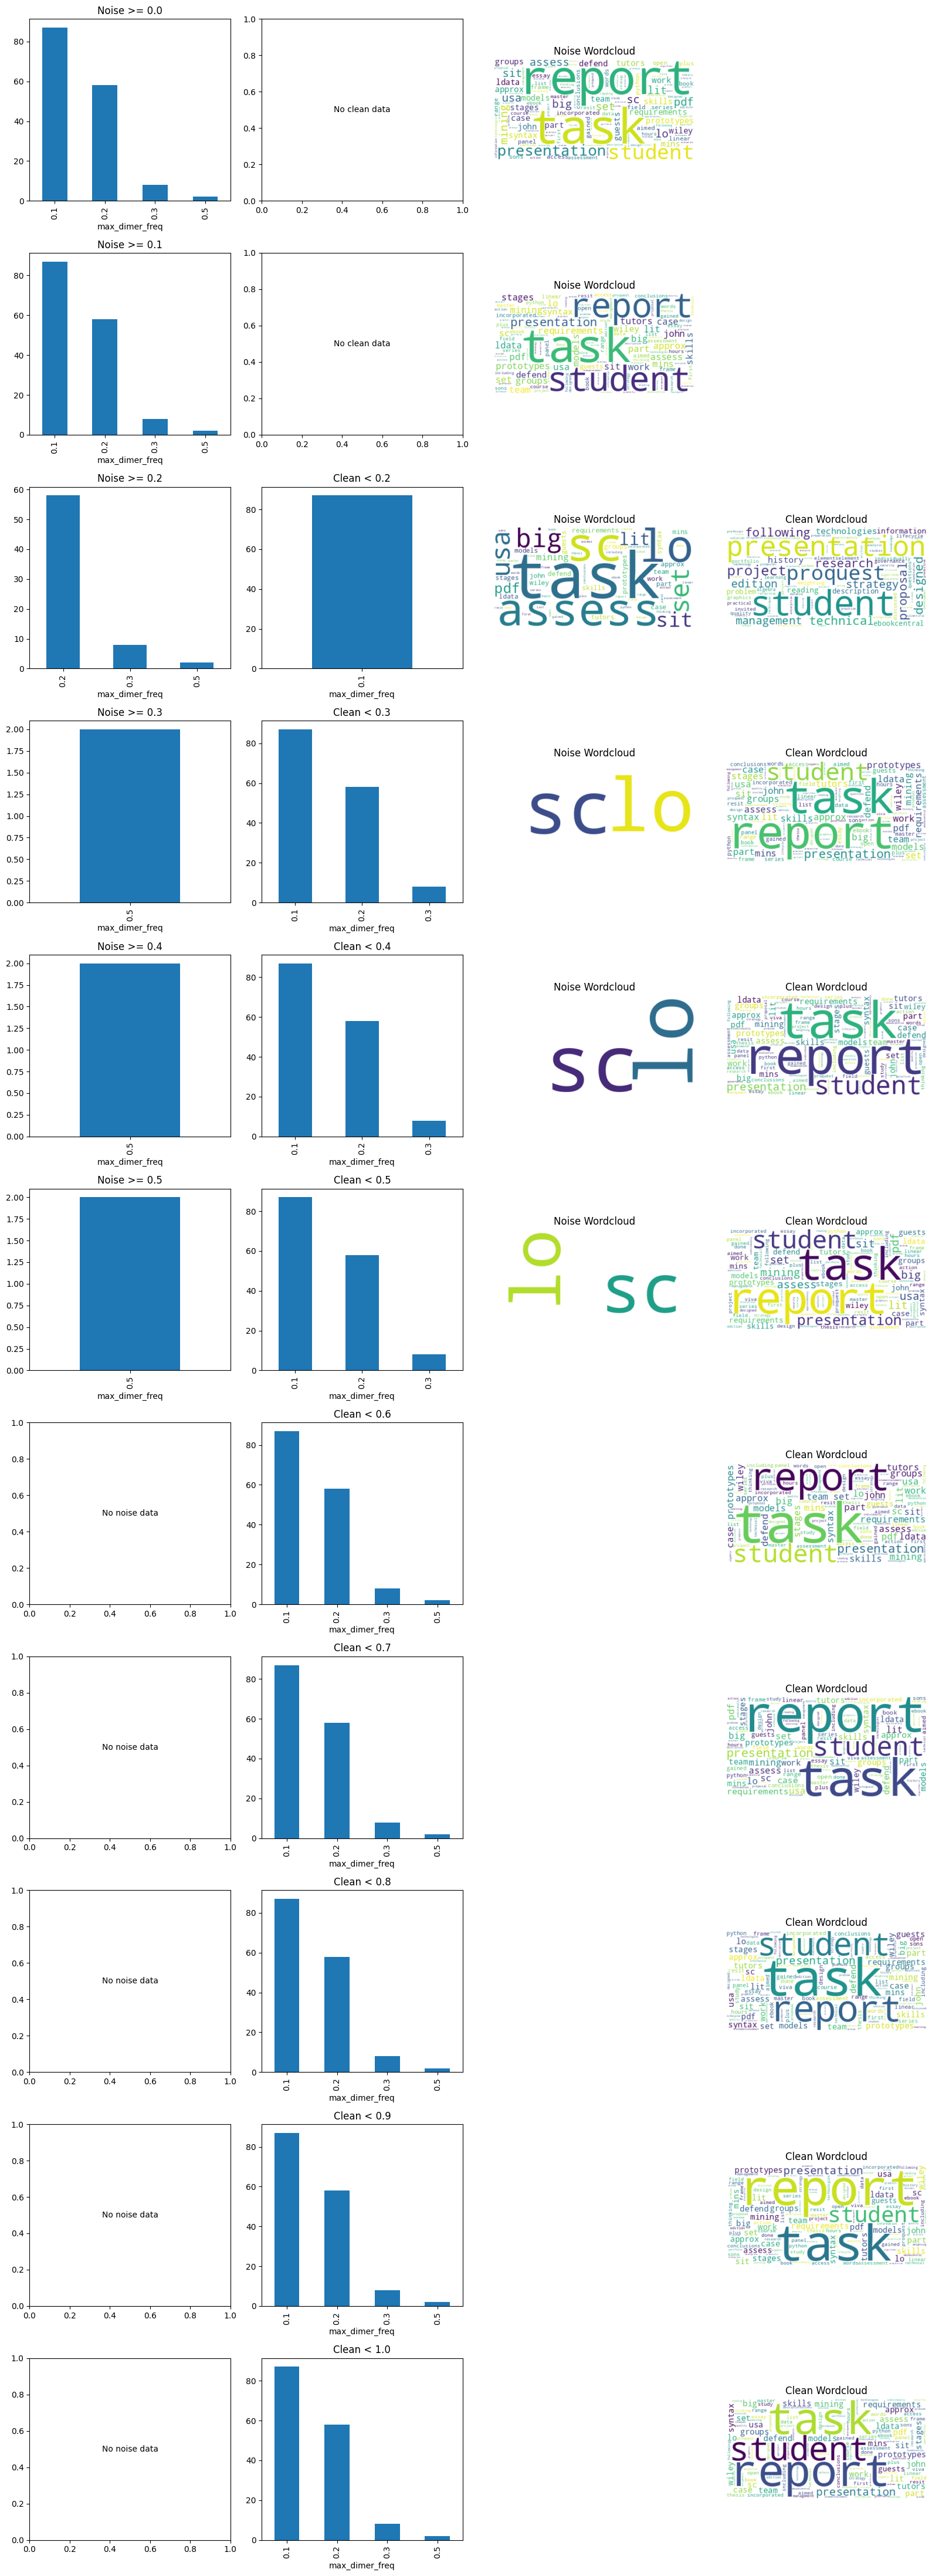

In [4]:
grid_plot(tsi_data)

# Notes on preprocessing
- dimer filtering frequency threshold was changed to 0.3 to avoid excluding document-specific terms (see grid plot above).
- stop word list was extended to include common words used in all the documents as they made it difficult for the model to infer document-specific terms

In [5]:
# To be used as target function to optimize model's parameters
def get_renyi_entropy(model, dictionary, num_topics):
    '''
    Function to calculate Renyi entropy 
    for hierarchical topic model 
    based on https://doi.org/10.7717/peerj-cs.608
    '''
    
    #Getting token probability distribution for each topic
    phi = model.get_phi()
    phi_np = phi.to_numpy()
    
    #Getting number of words in the dictionary
    W = int(str(dictionary).split(" ")[-1][:-1].split("=")[-1])
    
    #Calculating uniform distribution threshold value
    p_uniform = 1/W
    
    #Filtering the phi_wt matrix based on threshold
    phi_gt_uniform = phi_np[phi_np > p_uniform]
    
    #Getting number of entries above threshold
    N = len(phi_gt_uniform)
    
    #Getting number of topics in the model
    T = num_topics
    
    #Calculating Gibbs-Shannon entropy
    S = np.log(N/(W*T))
    
    #Calculating internal energy
    E = -np.log((1/T)*np.sum(phi_gt_uniform))
    
    #Calculating deformation parameter
    q = 1/T
    
    #Calculating Renyi entropy value
    S_qR = (-q*E+S)/(q-1)
    return S_qR

In [6]:
def train_hier_tm(
    batch_vectorizer:artm.BatchVectorizer,
    dictionary:artm.Dictionary, 
    scores:list,
    regularizers:list,
    num_levels:int,
    topics_per_level:list,
    n1:int,
    tau_dict_1:dict,
    n2:int,
    tau_dict_2:dict,
    n3:int,
    tau_dict_3:dict,
    n4:int,
    tau_dict_4:dict,
) -> (artm.ARTM, list):
    '''
    Wrapper to train hierarchical unimodal topic model
    using the algorithm suggested by https://doi.org/10.1007/978-3-030-61705-9_24
    '''
   
    
    # Defining the hierarchical model object as container for models to represent levels
    model_artm = artm.hARTM(
        regularizers = regularizers,
        scores=scores,
        cache_theta=True
    )
    
    # Background/Specific topics
    bg_topics = [f'topic_{i}' for i in range(1)]
    sp_topics = [f'topic_{i}' for i in range(1,num_levels)]
    
    #Adding levels to the model
    level_dict = {} # to access each level model by its id
    for i in range(num_levels):
        level_id = f'level_{i}'
        level_dict[level_id] = model_artm.add_level(
            num_topics=int(topics_per_level[i]),
            parent_level_weight = 0.5
        )
        

        #Initialize - as required by the documentation
        #https://docs.bigartm.org/en/latest/api_references/python_interface/hARTM.html#artm.hARTM.add_level
        level_dict[level_id].initialize(dictionary = cooc_dict)
        level_dict[level_id].fit_offline(
            batch_vectorizer      = batch_vectorizer, 
            num_collection_passes = 1)
        
    #Setting regularization coefficient for the 1st training session
    #Note - all levels share the same regularizers and regularization parameters
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_1['SparsePhi']
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_1['SparseTheta']
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_1['DecorrelatorPhi']
    
    #Performing first training session of n1 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n1)
    
    #Setting regularization coefficient for the 2nd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_2['SparsePhi']
    model_artm.get_level(0).regularizers['SparsePhi'].topic_names   = bg_topics
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_2['SparseTheta']
    model_artm.get_level(0).regularizers['SparseTheta'].topic_names = bg_topics
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_2['DecorrelatorPhi']
    
    #Performing second training session of n2 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n2)
    
    #Setting regularization coefficient for the 3rd training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau           = tau_dict_3['SparsePhi']
    model_artm.get_level(0).regularizers['SparsePhi'].topic_names   = sp_topics
    model_artm.get_level(0).regularizers['SparseTheta'].tau         = tau_dict_3['SparseTheta']
    model_artm.get_level(0).regularizers['SparseTheta'].topic_names = sp_topics
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau     = tau_dict_3['DecorrelatorPhi']
    
    #Performing third training session of n3 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n3)

    #Setting regularization coefficient for the 4th training session
    model_artm.get_level(0).regularizers['SparsePhi'].tau       = tau_dict_4['SparsePhi']
    model_artm.get_level(0).regularizers['SparsePhi'].topic_names   = sp_topics
    model_artm.get_level(0).regularizers['SparseTheta'].tau     = tau_dict_4['SparseTheta']
    model_artm.get_level(0).regularizers['SparseTheta'].topic_names = sp_topics
    model_artm.get_level(0).regularizers['DecorrelatorPhi'].tau = tau_dict_4['DecorrelatorPhi']
    
    #Performing fourth training session of n4 iterations through the corpus
    model_artm.fit_offline(
        batch_vectorizer      = batch_vectorizer, 
        num_collection_passes = n4)
    
    '''
    The steps below allow to expose parameters of the model and
    perform target function calculation which will be required to
    optimize parameters of the model.
    '''
    
    #Calculating Renyi entropy for each level and on-average
    S_qR_dict = {}
    mean_S_qR = 0
    # Calculation for level 1 is not relevant
    for i in range(1,num_levels):
        level_id = f'level_{i}'
        level = level_dict[level_id]
        S_qR = get_renyi_entropy(
            model=level, 
            dictionary=dictionary,
            num_topics=topics_per_level[i]
        )
        S_qR_dict[f'{level_id}'] = S_qR
        #Average Renyi entropy accross levels to use in score calculation
        mean_S_qR += S_qR/num_levels
    
    #Exposing regularization coefficients
    parameters = {
        'SparsePhi'       : [
            tau_dict_1['SparsePhi'],
            tau_dict_2['SparsePhi'],
            tau_dict_3['SparsePhi'],
            tau_dict_4['SparsePhi']
        ],
        'SparseTheta'     : [
            tau_dict_1['SparseTheta'],
            tau_dict_2['SparseTheta'],
            tau_dict_3['SparseTheta'],
            tau_dict_4['SparseTheta']
        ],
        'DecorrelatorPhi' : [
            tau_dict_1['DecorrelatorPhi'],
            tau_dict_2['DecorrelatorPhi'],
            tau_dict_3['DecorrelatorPhi'],
            tau_dict_4['DecorrelatorPhi']
        ],
        'TopicsPerLevel': topics_per_level
    }
    
    #Generating parameter list
    flat_params = sum(list(parameters.values()),[])    
    
    #Calculating target function for the model with given parameters
    #Target function defined based on https://doi.org/10.1007/978-3-030-61705-9_24
    #In terms of topic coherence score calculated using the core (p>0.3) for each topic
    min_fc_list = []
    mean_fc_list = []
    for i in range(num_levels):
        min_fc_list.append(min(model_artm.get_level(i)._score_tracker['TopKernelScore Coherence'].coherence[-1].values()))
        mean_fc_list.append(model_artm.get_level(0)._score_tracker['TopKernelScore Coherence'].average_coherence[-1])
    min_fcoherence = np.array(min_fc_list)
    mean_fcoherence = np.array(mean_fc_list)
    # Minimizing Entropy to select optimal number of topics at each level
    # Maximizing coherence to improve topic interpretability
    fitness = np.sum(min_fcoherence + mean_fcoherence) - mean_S_qR
    return model_artm, flat_params, fitness, parameters, mean_S_qR

In [7]:
def print_measures(model:list):
    '''
    Function to summarize final score values of single level.
    Additionally plots quality metric values accross training iterations for single level.
    '''
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(color='w')
        plt.show()

In [8]:
def print_tpc_top_tkns(model, num_levels):
    '''
    Print top tokens for each topic at every level of hierarchical ARTM model.
    '''
    for i in range(num_levels):
        print(f'\nlevel{i}\n')
        for topic_name in model.get_level(i).topic_names:
            print(
                topic_name + ': ', model.get_level(i).score_tracker['TopTokensScore'].last_tokens[topic_name])

In [9]:
def hellinger_distance(p, q):
    '''
    Function to calculate Hellinger distance 
    between two discrete probability distribution vectors.
    Based on https://doi.org/10.21469/22233792.2.2.05.
    '''
    #Ensure the vectors are numpy arrays and normalized to sum to 1
    p = np.array(p) / np.sum(p)
    q = np.array(q) / np.sum(q)
    #Calculate the Hellinger distance
    distance = np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / np.sqrt(2)
    return distance

In [10]:
def get_distance_matrix(model, level_id):
    '''Calculates pairwise Hellinger distances from combined theta and psi matrices'''
    
    if level_id == 0:
        #Psi is only available if current level has parent level associated with it
        theta_psi = model.get_level(level_id).get_theta()
    else:
        #getting document embeddings for a given level
        theta = model.get_level(level_id).get_theta()

        #getting topic embeddings in terms of parent level 
        psi = model.get_level(level_id).get_psi()
        #Including embeddings for parent topics with documents
        theta_psi = theta.join(psi)

    #Distance matrix between documents using hellinger distance
    hlg_matrix = np.zeros((len(theta_psi.columns), len(theta_psi.columns)))
    for i, col1 in enumerate(theta_psi.columns):
        for j, col2 in enumerate(theta_psi.columns):
            hlg_matrix[i, j] = hellinger_distance(theta_psi[col1].values, theta_psi[col2].values)
    hlg_df = pd.DataFrame(hlg_matrix, columns=theta_psi.columns, index=theta_psi.columns)
    return hlg_df

In [11]:
def get_spectral_clusters(distance_matrix, num_topics):
    '''
    Perform spectral clustering based on pairwise distance matrix 
    and number of topics for a given level of the model.
    Bhattacharyya coefficient is a similarity measure related to Helligner distance,
    based on https://doi.org/10.2478/bile-2022-0006:
        HD = (1 − BC)^1/2
        BC = 1 - HD^2 
    '''
    # Convert the distance matrix to a similarity matrix
    similarity_matrix = 1 - distance_matrix.to_numpy()**2

    # Apply spectral clustering
    clustering = SpectralClustering(n_clusters = num_topics, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(similarity_matrix)

    # 'labels' now contains the cluster assignments for each point
    return labels

In [12]:
def plot_clustering_results(dm, labels, threshold, level_id, n_components=2):
    '''
    Using Multidimensional Scaling to project distance matrix into 2D or 3D space 
    and visualize connections based on Hellinger distance threshold for a given level of the model.
    Based on https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/
    '''
    # Initialize MDS with the specified number of components (2D or 3D)
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=42) #to fix document positions on rerun
    
    #Get document names from distance matrix to annotate the points
    doc_names = dm.columns
    
    #Transform dm into required number of dimensions for visualization using MDS
    data_transformed = mds.fit_transform(dm.to_numpy())

    # Create a plot based on the number of components
    fig = plt.figure()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        plot_func = ax.scatter
    else:
        ax = fig.add_subplot(111)
        plot_func = ax.scatter

    # Configure color map
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster
    for label, color in zip(unique_labels, colors):
        idx = np.where(labels == label)[0]  # Indices of points in the current cluster
        if n_components == 3:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                data_transformed[idx, 2], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )
        else:
            plot_func(
                data_transformed[idx, 0], 
                data_transformed[idx, 1], 
                c=[color], 
                label=f"Cluster {label}", 
                edgecolor='k', 
                s=50, 
                alpha=0.7
            )

        # Annotate each point in the cluster
        for point in idx:
            text = doc_names[point] if 'topic' not in str(doc_names[point]) else f'{doc_names[point]}_{level_id-1}'
            if n_components == 3:
                ax.text(
                    data_transformed[point, 0], 
                    data_transformed[point, 1], 
                    data_transformed[point, 2], 
                    text, 
                    fontsize=9
                )
            else:
                plt.annotate(
                    text, 
                    (data_transformed[point, 0], data_transformed[point, 1]), 
                    textcoords="offset points",
                    xytext=(5,2),
                    ha='center',
                    fontsize=9
                )

    # Draw connections for distances below the threshold
    for i in range(len(data_transformed)):
        for j in range(i + 1, len(data_transformed)):
            if dm.iloc[i, j] < threshold:
                if n_components == 3:
                    ax.plot([data_transformed[i, 0], data_transformed[j, 0]],
                            [data_transformed[i, 1], data_transformed[j, 1]],
                            [data_transformed[i, 2], data_transformed[j, 2]], 'k-', alpha=0.1)
                else:
                    plt.plot([data_transformed[i, 0], data_transformed[j, 0]],
                             [data_transformed[i, 1], data_transformed[j, 1]], 'k-', alpha=0.1)

    plt.title(f'Spectral Clustering Results with MDS, level {level_id}')
    if n_components == 2:
        plt.xlabel('MDS1')
        plt.ylabel('MDS2')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.75) if n_components == 2 else None
    plt.show()

In [13]:
def plot_hierarchical_connections(model, num_levels, threshold=0.15, spacing = 25, image_width=15):
    '''
    Function to plot connections between topics in different layers
    of the hierarchical topic model based on probability threshold.
    '''
    
    # Extracting topic embedding matrices from the model
    matrix_list = []
    for level_id in range(1,num_levels):
        
        df = model.get_level(level_id).get_psi()
        df.columns = [f'{c}_{level_id-1}' for c in df.columns]
        df.index = [f'{c}_{level_id}' for c in df.index]
        matrix_list.append(df)

    G = nx.Graph()
    pos = {}
    layer_y = 0  # Y position for the first layer
    y_offset = -5  # Vertical offset for subsequent layers
    
    # Determine the total number of layers for positioning
    total_layers = len(matrix_list) + 1  # +1 to include the 0th layer explicitly

    # Image width for centering
    half_width = image_width / 2

    # Process the first dataframe separately
    first_df = matrix_list[0]
    columns = first_df.columns
    indices = first_df.index

    # Position columns of the first dataframe
    for i, col in enumerate(columns):        
        # Calculate positions
        current_x_positions = half_width - (len(columns) / 2 - i) * spacing
        pos[col] = (current_x_positions, layer_y)
        
    #Adding spacing between the first and 2nd layer
    layer_y += y_offset
    
    # Position indices of the first dataframe as the second layer
    for i, index in enumerate(indices):
        current_x_positions = half_width - (len(indices) / 2 - i) * spacing
        pos[index] = (current_x_positions, layer_y)
    

    # Add edges for the first dataframe based on Hellinger distance threshold
    for col in columns:
        for index in indices:
            if first_df.at[index, col] > threshold:
                G.add_edge(col, index)
                
    # Setting index of the first df as columns of the 2nd df
    columns = first_df.index
                
    # For subsequent dataframes, treat indices as the new layer connected to the previous layer's indices
    for i, df in enumerate(matrix_list[1:]):
        
        new_layer_y = layer_y + y_offset
        new_indices = df.index
        
        
        # Position new indices
        for i, index in enumerate(new_indices):
            new_x_positions = half_width - (len(new_indices) / 2 - i) * spacing
            pos[index] = (new_x_positions, new_layer_y)
        
        # Add edges based on threshold, connecting previous indices to new indices
        for col in columns:  # Previous layer's indices now act as "columns"
            if col not in df.columns:
                continue  # Skip this parent topic if it has no child subtopics in this level
            for index in new_indices:
                    if df.at[index, col] > threshold:
                        G.add_edge(col, index)
        
        # Update for the next iteration
        layer_y = new_layer_y
        columns = new_indices  # The current indices become "columns" for the next layer

    # Draw the graph
    plt.figure(figsize=(image_width, 3 * total_layers))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, edge_color='k')
    plt.axis('off')  # Turn off the axis for clarity
    plt.show()

In [14]:
def get_clustering_maxp_topic(model, labels, doc_names):
    '''
    Showing top-1 probability topic index vs cluster number for every document in table form.
    '''
    theta = model.get_theta().reset_index(drop=True)
    clusters = doc_names.join(pd.DataFrame(labels, columns=['cluster_id']))
    clusters = clusters.join(pd.DataFrame(theta.idxmax(), columns=['max_p_topic_id']))
    return clusters

In [15]:
def plot_sankey(df, title):
    # Create mappings for source and target
    source_target_df = df.groupby(['cluster_id', 'max_p_topic_id']).size().reset_index(name='count')

    # Map unique IDs for source and target
    cluster_ids = pd.Categorical(source_target_df['cluster_id'])
    max_p_topic_ids = pd.Categorical(source_target_df['max_p_topic_id'], categories=source_target_df['max_p_topic_id'].unique())

    source = cluster_ids.codes
    target = max_p_topic_ids.codes + cluster_ids.codes.max() + 1

    # Create figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=list(cluster_ids.categories) + list(max_p_topic_ids.categories)
        ),
        link=dict(
            source=source,
            target=target,
            value=source_target_df['count']
        ))])

    fig.update_layout(title_text=title, font_size=10)
    fig.show()

In [16]:
def plot_full_sankey(df, title='Sankey Diagram for Articles and Clusters'):
    # Extract cluster_id columns and doc_names
    cluster_columns = [col for col in df.columns if 'cluster_id' in col]
    
    # Initialize lists for sources, targets, labels, and customdata for hover info
    sources = []
    targets = []
    labels = []
    customdata = []  # Custom data for each link, including doc_name and source/target labels for hover
    label_to_id = {}  # Maps cluster labels to unique IDs
    current_id = 0
    
    # Process each row in the DataFrame
    for index, row in df.iterrows():
        for i in range(len(cluster_columns) - 1):
            source_label = f"{cluster_columns[i]}_{row[cluster_columns[i]]}"
            target_label = f"{cluster_columns[i+1]}_{row[cluster_columns[i+1]]}"
            
            # Assign unique IDs to new labels and add them to the labels list
            if source_label not in label_to_id:
                label_to_id[source_label] = current_id
                labels.append(source_label)
                current_id += 1
                
            if target_label not in label_to_id:
                label_to_id[target_label] = current_id
                labels.append(target_label)
                current_id += 1
            
            # Append source, target, and doc_name to the respective lists
            source_id = label_to_id[source_label]
            target_id = label_to_id[target_label]
            sources.append(source_id)
            targets.append(target_id)
            # For customdata, include both the document name and the source/target labels
            customdata.append([row['doc_names'], labels[source_id], labels[target_id]])
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=["-".join(label.split('_')[-2:]) for label in labels],  # Display cleaner label text
        ),
        link=dict(
            source=sources,
            target=targets,
            value=[1]*len(sources),  # Set all connection values to 1
            customdata=customdata,
            # Use hovertemplate to show document name, source, and destination
            hovertemplate='Document: %{customdata[0]}<br>Source: %{customdata[1]}<br>Destination: %{customdata[2]}<extra></extra>',
        ))])
    
    fig.update_layout(title_text=title, font_size=10)
    fig.show()

# Results for TSI dataset

In [17]:
#Preparing input
input_folder = '../Data/course_descriptions/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}tsi_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [18]:
#Preparing list of document names
with open(f'{input_folder}tsi_{n_gram_value}_vw.txt', 'r+') as file:
    contents = file.readlines()
doc_names = pd.DataFrame([doc.split(' ')[0] for doc in contents],columns=['doc_names'])

In [54]:
#Number of topics
num_levels = 1
topics_per_level = [4] #should be increasing with index

#Names of regularizers that will have different r.coeff-s. on different training iterations
regularizer_names = [
    'SparsePhi', 
    'SparseTheta',
    'DecorrelatorPhi',
]
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=0), # document should have limited number of topics
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=0), # topics should have core terms
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0), # topic distributions should not correlate
    artm.HierarchySparsingThetaRegularizer(name='Hierarchy', tau=5), # controlling the number of supertopic-subtopic connections
]
#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.5),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

#Regularization coefficients for the 1st training iteration
tau_dict_1 = dict(zip(regularizer_names, [0,0,2.5e+5]))
n1 = 10

#Regularization coefficients for the 2nd training iteration
tau_dict_2 = dict(zip(regularizer_names, [0.5,0.2,0]))
n2 = 10

#Regularization coefficients for the 3rd training iteration
tau_dict_3 = dict(zip(regularizer_names, [0.5,0.2,0]))
n3 = 10

#Regularization coefficients for the 4th training iteration
tau_dict_4 = dict(zip(regularizer_names, [0.5,0.2,0]))
n4 = 10

In [55]:
%%time
#Training the model
model, flat_parameters, score, parameters, mean_S_qR = train_hier_tm(
    batch_vectorizer = batch_vectorizer,
    dictionary = cooc_dict, 
    scores = scores,
    regularizers = regularizers,
    num_levels=num_levels,
    topics_per_level=topics_per_level,
    n1 = n1,
    tau_dict_1 = tau_dict_1,
    n2 = n2,
    tau_dict_2 = tau_dict_2,
    n3 = n3,
    tau_dict_3 = tau_dict_3,
    n4 = n4,
    tau_dict_4 = tau_dict_4,
)

CPU times: user 7.59 s, sys: 674 ms, total: 8.26 s
Wall time: 5.22 s


In [56]:
#Topics at each levels presented as top-10 tokens
print_tpc_top_tkns(model, num_levels)


level0

topic_0:  ['data', 'practical', 'study', 'tasks', 'learning', 'completed', 'information', 'independent', 'mining', 'part']
topic_1:  ['data', 'learning', 'study', 'report', 'including', 'words', 'design', 'action', 'independent', 'analytics']
topic_2:  ['research', 'thesis', 'study', 'students', 'information', 'thinking', 'presentation', 'master', 'critical', 'part']
topic_3:  ['project', 'practical', 'management', 'study', 'knowledge', 'written', 'development', 'requirements', 'information', 'quality']


### Figure 6. Quality metrics accross training iterations for hierarchical model - bioinformatics dataset


Results for level 0

Sparsity Phi: 0.000 
Sparsity Theta: 0.000
Kernel contrast: 0.571
Kernel purity: 0.341


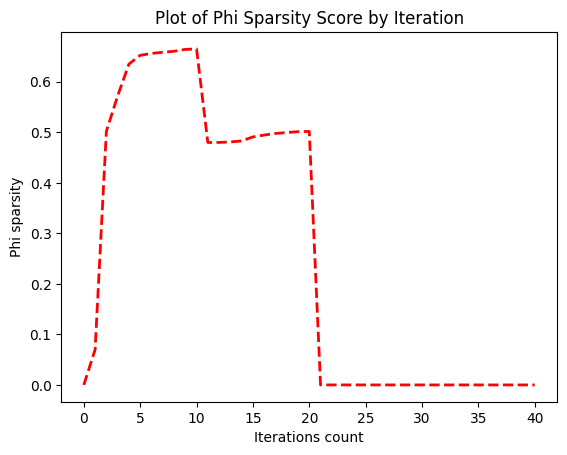

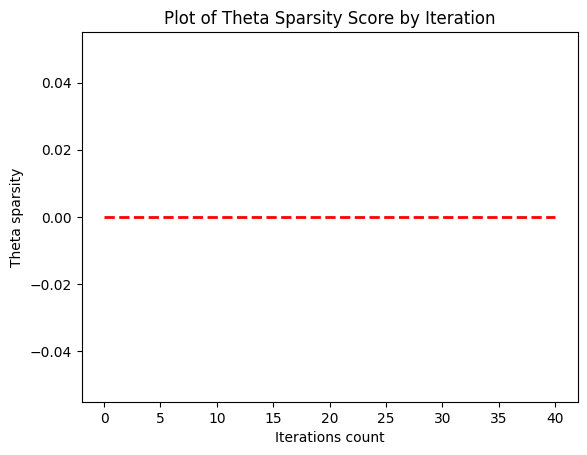

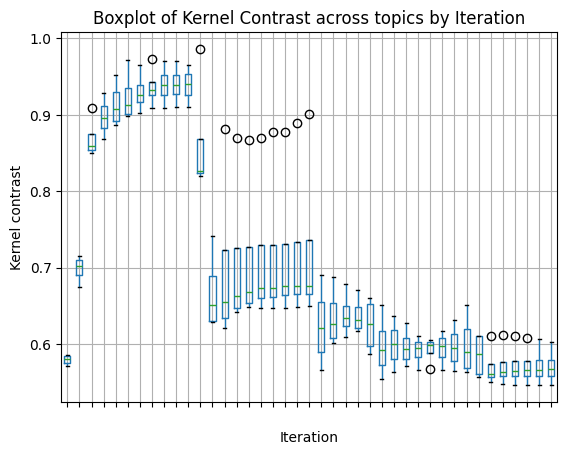

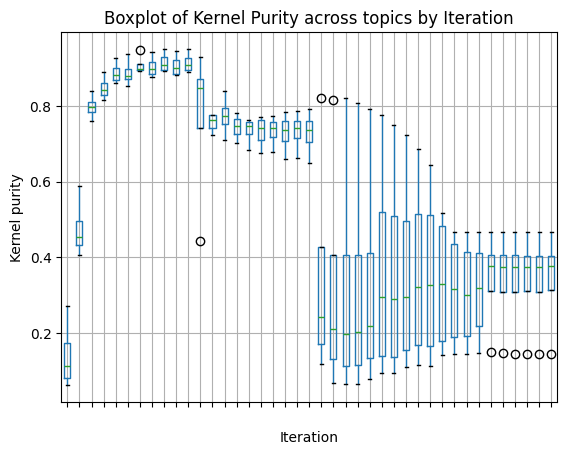

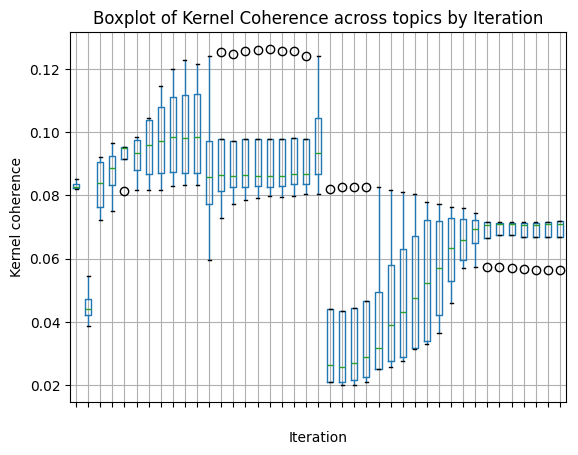

In [57]:
for level_id in range(num_levels):
    print(f'\nResults for level {level_id}\n')
    print_measures(model.get_level(level_id))

### Figure 7. Spectral clustering results - NLP dataset

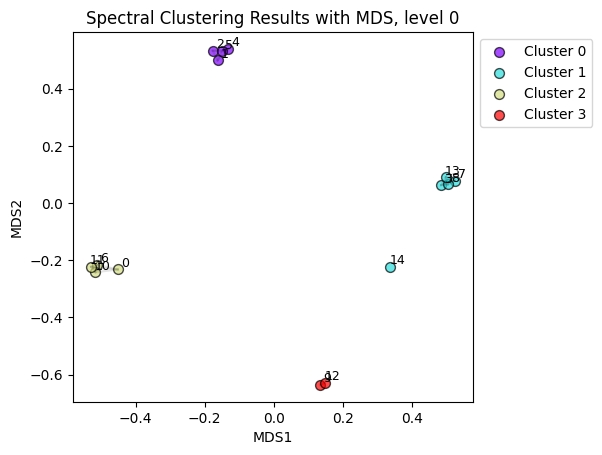

,doc_names,cluster_id,max_p_topic_id
1,M_100_04_Data_Mining,0,0
2,M_225_04_Cybersecurity_and_data_protection,0,0
4,M_227_04_Programming_for_data_analytics,0,0
5,M_228_04_Mathematics_for_data_analytics,0,0
3,M_226_04_Modern_Database_Technologies,1,1
7,M_232_04_Business_Intelligence_and_Data_Visualisation,1,1
8,M_233_04_Machine_Learning_and_Predictive_Analytics,1,1
13,M_546_04_Big_Data,1,1
14,M_900_01_Artificial_Intelligence_Group_Project,1,1
0,M_066_04_Information_Systems_and_Technologies,2,2


,doc_names,cluster_id_0
0,M_066_04_Information_Systems_and_Technologies,2
1,M_100_04_Data_Mining,0
2,M_225_04_Cybersecurity_and_data_protection,0
3,M_226_04_Modern_Database_Technologies,1
4,M_227_04_Programming_for_data_analytics,0
5,M_228_04_Mathematics_for_data_analytics,0
6,M_231_04_Research_Methodology,2
7,M_232_04_Business_Intelligence_and_Data_Visualisation,1
8,M_233_04_Machine_Learning_and_Predictive_Analytics,1
9,M_245_04_Quality_Models_of_Software_and_Information_Systems,3


In [58]:
#MDS-based visualization of spectral clustering results on document embeddings at each level
pd.set_option('display.max_colwidth', 100)
agg_clusters = None
for level_id in range(num_levels):
    dm = get_distance_matrix(model, level_id)
    labels = get_spectral_clusters(dm,topics_per_level[level_id])
    threshold = np.mean(dm.to_numpy()) - np.std(dm.to_numpy())
    plot_clustering_results(dm, labels, threshold, level_id)
    df = get_clustering_maxp_topic(model.get_level(level_id), doc_names=doc_names, labels=labels)
    if level_id == 0:
        agg_clusters = df[['doc_names', 'cluster_id']].rename(columns={'cluster_id':'cluster_id_0'})
    else:
        agg_clusters[f'cluster_id_{level_id}'] = df['cluster_id']
    sorted_df = df.sort_values(by=['cluster_id', 'max_p_topic_id'])
    display(sorted_df)
    plot_sankey(sorted_df, title=f'Sankey plot for clustering results and top-P topic id for level {level_id}.')
display(agg_clusters)
plot_full_sankey(agg_clusters)

In [59]:
plot_hierarchical_connections(model, num_levels, threshold=0.15, spacing = 25, image_width=15)

IndexError: list index out of range